In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import bindome as bd

In [4]:
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'

In [90]:
# load the MSA sequences, one hot encoded
import pickle
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))

### Remove cases without data

In [91]:
df = df[~pd.isnull(y)].reset_index(drop=True)
x = np.array(x)[~pd.isnull(y)]
x = np.array(list(map(lambda y: y.T, x)))
y = np.array(y)[~pd.isnull(y)]

/tmp/ipykernel_5445/2642820372.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)[~pd.isnull(y)]


In [92]:
# shuffle the data a bit
idx_sample = df.sample(df.shape[0]).index
df = df.reindex(idx_sample)


In [93]:
x = x[idx_sample]
y = y[idx_sample]

In [94]:
df.shape, x.shape, y.shape

((155, 2), (155, 88, 21), (155,))

In [95]:
# make all PWMs of length 15
for yi in y:
    dy = 15 - yi.shape[1]
    for i in range(yi.shape[1], 15):
        yi[i] = 0
y = np.array(list(map(lambda y: y.to_numpy(), y)))

In [96]:
df.shape, x.shape, y.shape

((155, 2), (155, 88, 21), (155, 4, 15))

In [97]:
# good prediction on such a low amount of data using LSTMs.
#first 200 for training

X_train = x[:100, :]
X_test = x[100:, :]

y_train = y[:100, :]
y_test = y[100:, :] 

In [98]:
X_train.shape, y_train.shape

((100, 88, 21), (100, 4, 15))

In [99]:
X_test.shape, y_test.shape

((55, 88, 21), (55, 4, 15))

In [100]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [101]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [102]:
#reshaping to rows, timestamps, features

# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

X_train_tensors_final = torch.Tensor(X_train_tensors)
X_test_tensors_final = torch.Tensor(X_test_tensors)

In [103]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([100, 88, 21]) torch.Size([100, 4, 15])
Testing Shape torch.Size([55, 88, 21]) torch.Size([55, 4, 15])


In [104]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.linear =  nn.Linear(hidden_size, 253) #fully connected 1

        self.conv_mono = nn.Linear(253, 60) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next

        out = self.relu(hn)
        
        # print('linear')
        # print(out.shape)
        out = self.linear(out) #first Dense
        
        # print(out.shape)
        out = self.relu(out) #relu
        # print(out.shape)
        
        out = self.conv_mono(out) #Final Output
        return out.reshape(x.shape[0], 4, 15)
 

In [105]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 21 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 




In [106]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [107]:
y_train_tensors.shape

torch.Size([100, 4, 15])

In [108]:
y_train_tensors.shape

torch.Size([100, 4, 15])

In [109]:
num_epochs = 5000

In [110]:
for epoch in range(num_epochs):
    outputs = lstm.forward(X_train_tensors_final) #forward pass
    
    # print(outputs.shape)
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    
    loss.backward() #calculates the loss of the loss function
    
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 200 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.09878
Epoch: 200, loss: 0.01809
Epoch: 400, loss: 0.01728
Epoch: 600, loss: 0.01657
Epoch: 800, loss: 0.01612
Epoch: 1000, loss: 0.01555
Epoch: 1200, loss: 0.01530
Epoch: 1400, loss: 0.01522
Epoch: 1600, loss: 0.01516
Epoch: 1800, loss: 0.01511
Epoch: 2000, loss: 0.01502
Epoch: 2200, loss: 0.01488
Epoch: 2400, loss: 0.01475
Epoch: 2600, loss: 0.01462
Epoch: 2800, loss: 0.01452
Epoch: 3000, loss: 0.01444
Epoch: 3200, loss: 0.01437
Epoch: 3400, loss: 0.01431
Epoch: 3600, loss: 0.01426
Epoch: 3800, loss: 0.01421
Epoch: 4000, loss: 0.01417
Epoch: 4200, loss: 0.01413
Epoch: 4400, loss: 0.01410
Epoch: 4600, loss: 0.01408
Epoch: 4800, loss: 0.01405


In [111]:
X_train_tensors_final.shape

torch.Size([100, 88, 21])

In [112]:
X_test_tensors_final.shape

torch.Size([55, 88, 21])

In [113]:
X_train_tensors_final.shape

torch.Size([100, 88, 21])

In [114]:
X_test_tensors_final.shape

torch.Size([55, 88, 21])

In [115]:
y_pred = lstm(X_test_tensors_final).detach().numpy()#forward pass
y_pred.shape

(55, 4, 15)

In [116]:
import logomaker


In [120]:
import seaborn as sns


In [123]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 1
rcParams['figure.dpi'] = 30

In [124]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 1
rcParams['figure.dpi'] = 100

0.5020641

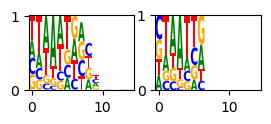

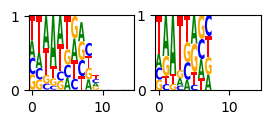

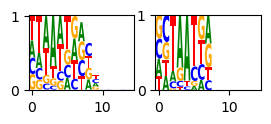

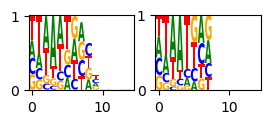

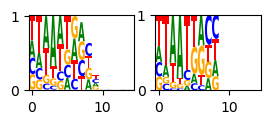

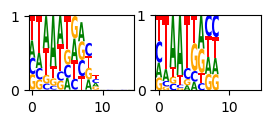

In [155]:
y_train = lstm(X_train_tensors_final).detach().numpy()#forward pass

yi = None

sq_err_train = []
for i in range(y_train.shape[0]):

    yi = y_train[i]
    # print(yi.shape)
    # print(yi)
    yi = pd.DataFrame(yi)
    yi.columns = [int(ci) for ci in range(yi.shape[1])]
    yi.index = 'A', 'C', 'G', 'T'

    yi_train = y_train_tensors[i].detach().numpy()

    sq_err = np.sum(((yi - yi_train) ** 2).to_numpy().flatten())
    sq_err_train.append(sq_err)
    
    if i > 5:
        continue
            
    ax = plt.subplot(1, 2, 1)
    logomaker.Logo(yi.T, shade_below=0.5, fade_below=0.5, ax=ax)

    yi_train = pd.DataFrame(yi_train)
    yi_train.columns = [int(ci) for ci in range(yi_train.shape[1])]
    yi_train.index = 'A', 'C', 'G', 'T'

    ax = plt.subplot(1, 2, 2)
    logomaker.Logo(yi_train.T, shade_below=0.5, fade_below=0.5, ax=ax)
    plt.show()

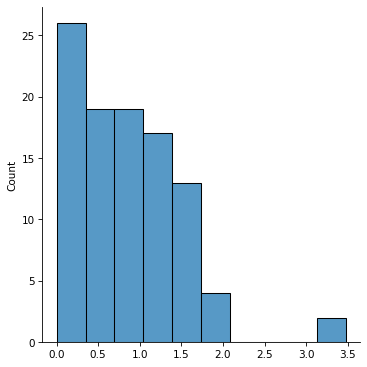

In [160]:
rcParams['figure.figsize'] = 6, 1
rcParams['figure.dpi'] = 75

sns.displot(sq_err_train)

In [126]:
y_pred = lstm(X_test_tensors_final).detach().numpy()#forward pass

In [134]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 1
rcParams['figure.dpi'] = 100

<AxesSubplot:>

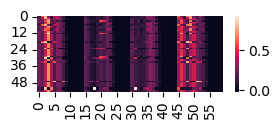

In [135]:
import seaborn as sns
sns.heatmap(y_pred.reshape(55, 60))

In [136]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 1
rcParams['figure.dpi'] = 100

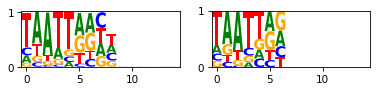

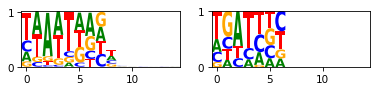

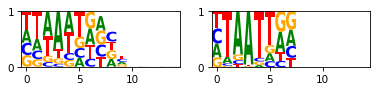

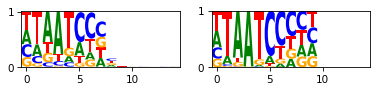

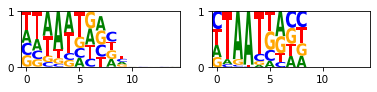

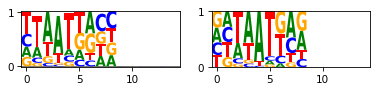

In [161]:
sq_err_test = []
for i in range(y_pred.shape[0]):

    yi = y_pred[i]
    # print(yi.shape)
    # print(yi)
    yi = pd.DataFrame(yi)
    yi.columns = [int(ci) for ci in range(yi.shape[1])]
    yi.index = 'A', 'C', 'G', 'T'

    yi_test = y_test_tensors[i].detach().numpy()

    sq_err = np.sum(((yi - yi_test) ** 2).to_numpy().flatten())
    sq_err_test.append(sq_err)
    
    if i > 5:
        continue
            
    ax = plt.subplot(1, 2, 1)
    logomaker.Logo(yi.T, shade_below=0.5, fade_below=0.5, ax=ax)

    yi_test = pd.DataFrame(yi_test)
    yi_test.columns = [int(ci) for ci in range(yi_test.shape[1])]
    yi_test.index = 'A', 'C', 'G', 'T'

    ax = plt.subplot(1, 2, 2)
    logomaker.Logo(yi_test.T, shade_below=0.5, fade_below=0.5, ax=ax)
    plt.show()

<AxesSubplot:xlabel='label', ylabel='err'>

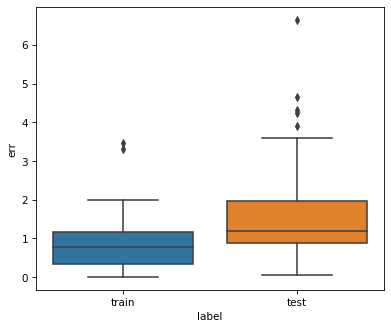

In [167]:
rcParams['figure.figsize'] = 6, 5
rcParams['figure.dpi'] = 75

data = pd.DataFrame()
data['err'] = sq_err_train + sq_err_test 
data['label'] = np.where(data.index > len(sq_err_train), 'test', 'train')
sns.boxplot(data=data, x='label', y='err')